# PART 3

### PREPARE THE DATA

In [404]:
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy import random

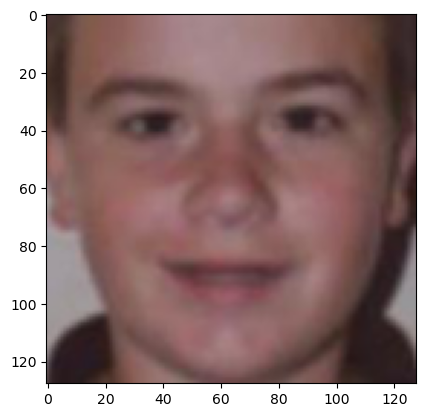

In [438]:
class Faces(Dataset):
    def __init__(self, root_dir="data", keep_prob=1):
        self.root_dir = root_dir
        self.data = []
        for file in os.listdir(root_dir):
            if file.endswith(".jpg"):
                if random.random() < keep_prob:
                    age = int(file.split("_")[0])
                    self.data.append({"path": file, "age": age})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        full_path = os.path.join(self.root_dir, sample["path"])
        image = Image.open(full_path).convert("RGB").resize((128, 128))
        image = np.array(image)
        age = sample["age"]
        return image, age


fcs = Faces()
plt.imshow(fcs.__getitem__(3)[0])

In [439]:
dataset = Faces()
# Convert dataset to data and labels
images = []
ages = []

for img, age in dataset:
    images.append(img)
    ages.append(age)

# First split into train and temp (test + val)
X_train, X_temp, y_train, y_temp = train_test_split(images, ages, test_size=0.4, random_state=42)

# Then split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Atribute based

In [450]:
# Reshape to features vectors
X_train_basic = [x.reshape(-1) for x in X_train]
X_val_basic = [x.reshape(-1) for x in X_val]
X_test_basic = [x.reshape(-1) for x in X_test]

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train_basic)

X_train_basic = scaler.transform(X_train_basic)
X_val_basic   = scaler.transform(X_val_basic)   
X_test_basic = scaler.transform(X_test_basic)

In [441]:
from hw_kernels import SVR, RBF, Polynomial, Linear, KernelizedRidgeRegression
from sklearn.metrics import mean_squared_error

lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
sigmas = [1, 10, 100, 1000]

best_score = float('inf')
best_params = None

# parameter tuning
for lambda_ in lambdas:
    for sigma in sigmas:
        kernel = RBF(sigma=sigma)
        fitter = KernelizedRidgeRegression(kernel, lambda_=lambda_)
        model = fitter.fit(X_train_basic, y_train)
        preds = model.predict(X_val_basic)
        score = mean_squared_error(y_val, preds)
        print(f"lambda={lambda_}, sigma={sigma} → MSE={score:.4f}")

        if score < best_score:
            best_score = score
            best_params = {'lambda': lambda_, 'sigma': sigma}

print("\nBest parameters:", best_params)
print("Best validation MSE:", best_score)


lambda=0.0001, sigma=1 → MSE=1142.5611
lambda=0.0001, sigma=10 → MSE=1141.6129
lambda=0.0001, sigma=100 → MSE=229.5487
lambda=0.0001, sigma=1000 → MSE=288.5985
lambda=0.001, sigma=1 → MSE=1142.5710
lambda=0.001, sigma=10 → MSE=1141.6236
lambda=0.001, sigma=100 → MSE=229.5662
lambda=0.001, sigma=1000 → MSE=229.1508
lambda=0.01, sigma=1 → MSE=1142.6708
lambda=0.01, sigma=10 → MSE=1141.7314
lambda=0.01, sigma=100 → MSE=229.7479
lambda=0.01, sigma=1000 → MSE=202.8007
lambda=0.1, sigma=1 → MSE=1143.7404
lambda=0.1, sigma=10 → MSE=1142.8743
lambda=0.1, sigma=100 → MSE=232.8201
lambda=0.1, sigma=1000 → MSE=227.6945
lambda=1, sigma=1 → MSE=1153.5838
lambda=1, sigma=10 → MSE=1153.0975
lambda=1, sigma=100 → MSE=276.3384
lambda=1, sigma=1000 → MSE=294.6776

Best parameters: {'lambda': 0.01, 'sigma': 1000}
Best validation MSE: 202.8007141665641


In [451]:
# fitting 
X_train_basic = np.vstack([X_train_basic, X_val_basic])
y_tmp = np.concatenate([y_train, y_val])
fitter = KernelizedRidgeRegression(RBF(sigma=1000), lambda_=0.01)
model = fitter.fit(X_train_basic, y_tmp)

In [452]:
preds = model.predict(X_test_basic)
mses = (y_test - preds)**2 
print(f"MSE = {np.mean(mses)} +/- {np.std(mses) / np.sqrt(len(preds))}")

MSE = 195.45975175763536 +/- 24.287894586315364


### Custom kernel

In [444]:
def normalize_images(X):
    normed = []
    for img in X:
        img = img.astype(np.float32)
        img = img/255
        normed.append(img)
    return normed

In [445]:
X_train_my_kernel= normalize_images(X_train)
X_val_my_kernel = normalize_images(X_val)
X_test_my_kernel = normalize_images(X_test)

In [446]:
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray

class MyKernel:
    def __init__(self, basic_kernel, pixels_per_cell=(8, 8)):
        self.basic_kernel = basic_kernel
        self.pixels_per_cell = pixels_per_cell

    def _extract_hog_features(self, images):
        features = []
        for img in images:
            img = rgb2gray(img)

            hog_feat = hog(
                img,
                pixels_per_cell=self.pixels_per_cell,
                cells_per_block=(2, 2),
                feature_vector=True
            )
            features.append(hog_feat)
        return np.array(features)


    def __call__(self, A, B):
        A_feats = self._extract_hog_features(A)
        B_feats = self._extract_hog_features(B)
        return self.basic_kernel(A_feats, B_feats)


In [447]:
from sklearn.metrics import mean_squared_error

lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]
sigmas = [0.1, 1, 10, 100]
pixels_per_cells = [(4, 4), (8, 8), (16, 16)]  # Add more variations here

best_score = float('inf')
best_params = None

for lambda_ in lambdas:
    for sigma in sigmas:
        for ppc in pixels_per_cells:
            base_kernel = RBF(sigma=sigma)
            kernel = MyKernel(basic_kernel=base_kernel, pixels_per_cell=ppc)

            fitter = KernelizedRidgeRegression(kernel, lambda_=lambda_)
            model = fitter.fit(X_train_my_kernel, y_train)
            preds = model.predict(X_val_my_kernel)
            score = mean_squared_error(y_val, preds)

            print(f"λ={lambda_}, σ={sigma}, ppc={ppc} → MSE={score:.4f}")

            if score < best_score:
                best_score = score
                best_params = {
                    'lambda': lambda_,
                    'sigma': sigma,
                    'pixels_per_cell': ppc
                }

print("\nBest parameters:", best_params)
print("Best validation MSE:", best_score)


λ=0.0001, σ=0.1, ppc=(4, 4) → MSE=1142.5611
λ=0.0001, σ=0.1, ppc=(8, 8) → MSE=1142.5611
λ=0.0001, σ=0.1, ppc=(16, 16) → MSE=1142.5611
λ=0.0001, σ=1, ppc=(4, 4) → MSE=1142.5611
λ=0.0001, σ=1, ppc=(8, 8) → MSE=1142.5611
λ=0.0001, σ=1, ppc=(16, 16) → MSE=1116.6357
λ=0.0001, σ=10, ppc=(4, 4) → MSE=401.4730
λ=0.0001, σ=10, ppc=(8, 8) → MSE=153.0398
λ=0.0001, σ=10, ppc=(16, 16) → MSE=252.6646
λ=0.0001, σ=100, ppc=(4, 4) → MSE=162.2928
λ=0.0001, σ=100, ppc=(8, 8) → MSE=167.2167
λ=0.0001, σ=100, ppc=(16, 16) → MSE=237.3160
λ=0.001, σ=0.1, ppc=(4, 4) → MSE=1142.5709
λ=0.001, σ=0.1, ppc=(8, 8) → MSE=1142.5710
λ=0.001, σ=0.1, ppc=(16, 16) → MSE=1142.5710
λ=0.001, σ=1, ppc=(4, 4) → MSE=1142.5710
λ=0.001, σ=1, ppc=(8, 8) → MSE=1142.5710
λ=0.001, σ=1, ppc=(16, 16) → MSE=1116.6678
λ=0.001, σ=10, ppc=(4, 4) → MSE=401.5796
λ=0.001, σ=10, ppc=(8, 8) → MSE=153.0651
λ=0.001, σ=10, ppc=(16, 16) → MSE=244.4554
λ=0.001, σ=100, ppc=(4, 4) → MSE=162.5937
λ=0.001, σ=100, ppc=(8, 8) → MSE=160.5377
λ=0.001, σ=100

In [448]:
base_kernel = RBF(sigma=10)  # RBF kernel with sigma=10
kernel = MyKernel(basic_kernel=base_kernel, pixels_per_cell=(8, 8))  # or your preferred ppc

fitter = KernelizedRidgeRegression(kernel, lambda_=0.0001)

X_combined = np.vstack([X_train_my_kernel, X_val_my_kernel])
y_combined = np.concatenate([y_train, y_val])

model = fitter.fit(X_combined, y_combined)

In [449]:
preds = model.predict(X_test_my_kernel)
mses = (y_test - preds)**2 
print(f"MSE = {np.mean(mses)} +/- {np.std(mses) / np.sqrt(len(preds))}")

MSE = 137.79265417563585 +/- 24.617288457771732
